<a href="https://colab.research.google.com/github/dniggl/Insights/blob/main/Customer_Segmentation_using_K_Means_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Build a K-Means clustering algorithm for customer segmentation.


**Import the required software libraries**

In [ ]:
# Import the source libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import cluster

**Load and Store the Data**

In [ ]:
# Load the data on Google Colab
from google.colab import files 
uploaded = files.upload() 

Saving Online Retail.xlsx to Online Retail.xlsx


In [ ]:
# Store retail data into a data frame variable.
retail = pd.read_excel('Online Retail.xlsx', sheet_name='Online Retail')

**Data Analysis**

Print the first 5 rows of the data frame.

In [ ]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


This data came from Kaggle's website. The dataset contains all purchases made for an online retail company based in the United Kingdom during an eight month period. The data can be found here https://www.kaggle.com/vijayuv/onlineretail

The columns and definitions are listed below.

1. InvoiceNo - invoice number.  

2. StockCode - stock identifier for a product. 

3. Description - description of product. 

4. Quantity - quantity of product purchased. 

5. InvoiceDate - date incoice was created (yyyy-mm-dd).  

6. UnitPrice - price for a single product.

7. CustomerID - unique identifier for each customer.

8. Country - country where product was purchased.

Show information about the data columns.

In [ ]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


There are 541,909 invoice records and 8 columns. The variables contain alpha-numeric, numeric and date data types. There are null or missing values in Description, CustomerID columns. 

**Data Cleanup and Transformations**

Remove records that do not have a customer ID. 

In [ ]:
# Drop records without CustomerID.
retail = retail[pd.notnull(retail['CustomerID'])]

Add total sales amount column for each invoice in the dataframe. This is calculated by multiplying quantity times the unit price for each row.

In [ ]:
retail['Sales'] = retail['Quantity'] * retail['UnitPrice']
retail.head(5) 

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,20.34


We need to transform  the data so that each record represents a single customer's purchase history. We will use groupby feature to summarize sales amounts by CustomerID. The lambda function will be used to sum the number of invoices by Customer ID.

In [ ]:
# Use groupby feature to summarize sales by CustomerID.  
customer_retail = retail.groupby('CustomerID').agg({'Sales': sum, 
                                            'InvoiceNo': lambda x: x.nunique()})
customer_retail.head(5)

,Sales,InvoiceNo
CustomerID,,
12346.0,0.00,2
12347.0,4310.00,7
12348.0,1797.24,4
12349.0,1757.55,1
12350.0,334.40,1


We will select the columns in the data frame that we want to use for our analysis and rename the column names to be more intuitive. 

In [ ]:
# Select the columns we want to use and rename the column names.
customer_retail.columns = ['TotalSales', 'OrderCount'] 
customer_retail.head(5)

,TotalSales,OrderCount
CustomerID,,
12346.0,0.00,2
12347.0,4310.00,7
12348.0,1797.24,4
12349.0,1757.55,1
12350.0,334.40,1


Create a new column for average order value for each customer in the data frame. This is calculated by dividing the total sales amount by the order count for each row.

In [ ]:
# Create a new column named Average Order Value.
customer_retail['AvgOrderValue'] = customer_retail['TotalSales'] / customer_retail['OrderCount']
customer_retail.head()

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,0.00,2,0.000000
12347.0,4310.00,7,615.714286
12348.0,1797.24,4,449.310000
12349.0,1757.55,1,1757.550000
12350.0,334.40,1,334.400000



**Normalize the Data**

We need to normalize the data so that its distribution will have a mean value 0 and standard deviation of 1. Normalization makes the features more consistent with each other, which allows the model to predict outputs more accurately. This is done for each feature or column of the data. The rank (method=first) function ranks the data in the order in which they appear in the data frame.

In [ ]:
# Normalize the data so that its distribution will have 
# a mean value 0 and standard deviation of 1. 
rank_retail = customer_retail.rank(method='first')
normalized_retail = (rank_retail - rank_retail.mean()) / rank_retail.std()
normalized_retail.head()

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,-1.697390,-0.691236,-1.697390
12347.0,1.479522,1.026356,1.431195
12348.0,0.956639,0.344231,1.149155
12349.0,0.934456,-1.731457,1.702143
12350.0,-0.704704,-1.730664,0.669845


We will be using the K-means clustering algorithm to segment our customer invoice data. This is an unsupervised learning algorithm which aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest centroid (center of the cluster). The algorithm's goal is to minimize the squared Euclidean distances between the observation and the centroid of the cluster to which it belongs. If you would like to learn more about K-means clustering algorithm go to this website https://www.analyticsvidhya.com/blog/2021/11/understanding-k-means-clustering-in-machine-learningwith-examples/ 


We will use the elbow method of K-means clustering algorithm to choose the optimum number of clusters. The elbow method is one of the most popular methods used to select the optimal number of clusters by fitting the model with a range of values for K in the K-means algorithm. Elbow method requires drawing a line plot between SSE (Sum of Squared errors) vs number of clusters and finding the point representing the “elbow point” (the point after which the SSE or inertia starts decreasing in a linear fashion).

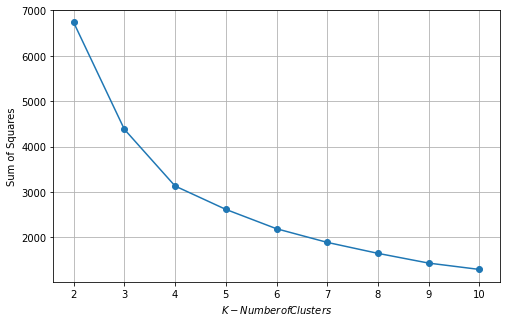

In [ ]:
# Use the elbow method to determine the best value for number of clusters.

sse = []
krange = list(range(2,11))
X = normalized_retail[['TotalSales','OrderCount','AvgOrderValue']].values
for n in krange:
    model = cluster.KMeans(n_clusters=n, random_state=3)
    model.fit_predict(X)
    cluster_assignments = model.labels_
    centers = model.cluster_centers_
    sse.append(np.sum((X - centers[cluster_assignments]) ** 2))

# Plot the results.
fig = plt.figure(figsize = (8,5))
plt.plot(krange, sse, marker='o')
plt.xlabel("$K - Number of Clusters$")
plt.ylabel("Sum of Squares")
plt.grid(True)
plt.show()

The image shows 4 clusters as the optimal number of clusters for this analysis. If we increase the number of clusters to more than 4, there is very small change in the inertia or sum of the squared distance.

We now need to train the k-means clustering model on the normalized data frame  using the optimal number of clusters found which is 4. The model goes through the training data and assigns each data point to the cluster whose centroid is closer to the data point. We will also add the cluster number to each row that the data falls into in the data frame.  

In [ ]:
# Train the k-means clustering model and add the cluster number that 
# the data falls into for each row.   he model goes through the training data and assigns them to the cluster whose centroid is closer to them. 
kmeans = KMeans(n_clusters=4).fit(normalized_retail[['TotalSales', 'OrderCount', 'AvgOrderValue']])
four_clusters = normalized_retail[['TotalSales', 'OrderCount', 'AvgOrderValue']].copy(deep=True)
four_clusters['Cluster'] = kmeans.labels_
four_clusters.head(5)

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,-1.697390,-0.691236,-1.697390,3
12347.0,1.479522,1.026356,1.431195,0
12348.0,0.956639,0.344231,1.149155,0
12349.0,0.934456,-1.731457,1.702143,1
12350.0,-0.704704,-1.730664,0.669845,1


Each row in the data frame is now assigned to a specific cluster.

We will now create a new data frame from the previous data frame where each record represented a single customer's purchase history prior to normalization. We will also add the cluster column to this data frame. 

In [ ]:
# Create a new data frame from summarized customer's purchase history 
# prior to normalization. Also add cluster column to the new data frame. 
df = customer_retail
frame = pd.DataFrame(df)
frame['Cluster'] = four_clusters['Cluster']
frame.head(5)

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,0.00,2,0.000000,3
12347.0,4310.00,7,615.714286,0
12348.0,1797.24,4,449.310000,0
12349.0,1757.55,1,1757.550000,1
12350.0,334.40,1,334.400000,1


**Data Visualization**

Text(0, 0.5, 'Total Sales ($)')

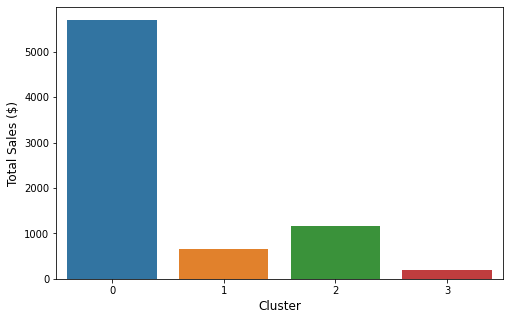

In [ ]:
# Visualize the relationship between total sales and each cluster.
fig = plt.figure(figsize = (8,5))
sns.barplot(x = 'Cluster', 
            y = 'TotalSales', 
            data = frame,
            ci = None)
# Add labels.
plt.xlabel("Cluster", size=12)
plt.ylabel("Total Sales ($)", size=12)

Text(0, 0.5, 'Order Count')

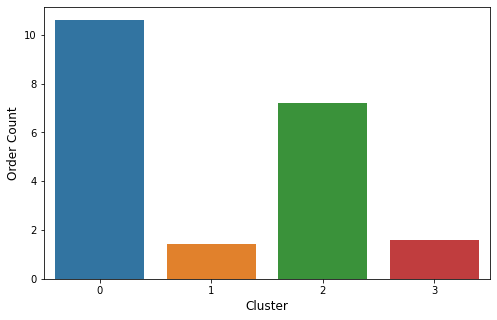

In [ ]:
# Visualize the relationship between order count and each cluster.
fig = plt.figure(figsize = (8,5))
sns.barplot(x = 'Cluster', 
            y = 'OrderCount', 
            data = frame,
            ci = None)
# Add labels
plt.xlabel("Cluster", size=12)
plt.ylabel("Order Count", size=12)

Text(0, 0.5, 'Average Order Value')

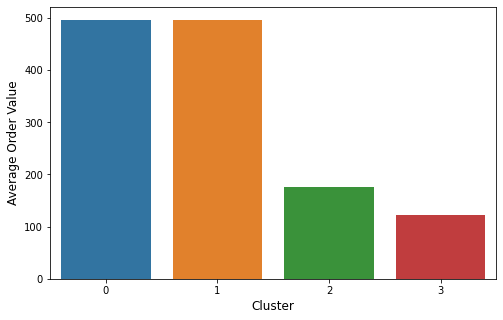

In [ ]:
# Visualize the relationship between average order value and each cluster.
fig = plt.figure(figsize = (8,5))
sns.barplot(x = 'Cluster', 
            y = 'AvgOrderValue', 
            data = frame,
            ci = None)
# Add labels.
plt.xlabel("Cluster", size=12)
plt.ylabel("Average Order Value", size=12)

Create a data frame including the average of all data points within each of the 4 clusters. The data points include total sales, order count and average order value. The center of the cluster is the average of all points (elements) within that cluster.  

In [ ]:
# Create a data frame including the average of all data points within each of the 4 clusters.
# The center of the cluster is the average of all points (elements) within that cluster.
cluster1_metrics = kmeans.cluster_centers_[0]
cluster2_metrics = kmeans.cluster_centers_[1]
cluster3_metrics = kmeans.cluster_centers_[2]
cluster4_metrics = kmeans.cluster_centers_[3]

data = [cluster1_metrics, cluster2_metrics, cluster3_metrics, cluster4_metrics]
cluster_center_df = pd.DataFrame(data)
# Add the column lables.
cluster_center_df.columns = four_cluster_df.columns[0:3]
cluster_center_df

,TotalSales,OrderCount,AvgOrderValue
0,1.213328,0.980835,0.869117
1,-1.191435,-0.741512,-0.999662
2,0.345987,0.791134,-0.609857
3,-0.160480,-0.889139,0.882628


The cluster numbers are shown in the far left column. 
0 is cluster 1, 1 is cluster 2, 2 is cluster 3, and 3 is cluster 4.


Visualize the clusters for total sales by order count. 

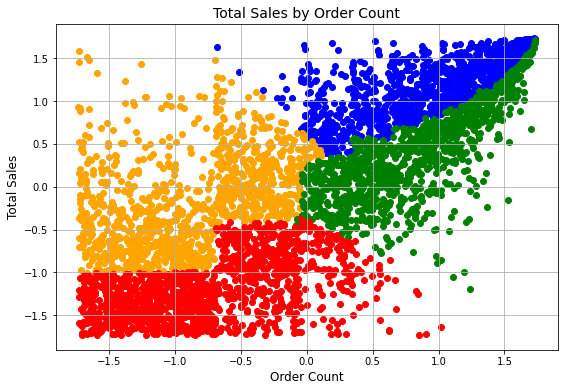

In [ ]:
# Visualize the clusters for total sales by order count.
fig = plt.figure(figsize = (9,6))
plt.scatter(
    four_clusters.loc[four_clusters['Cluster'] == 0]['OrderCount'], 
    four_clusters.loc[four_clusters['Cluster'] == 0]['TotalSales'],
    c='blue')

plt.scatter(
    four_clusters.loc[four_clusters['Cluster'] == 1]['OrderCount'], 
    four_clusters.loc[four_clusters['Cluster'] == 1]['TotalSales'],
    c='orange')

plt.scatter(
    four_clusters.loc[four_clusters['Cluster'] == 2]['OrderCount'], 
    four_clusters.loc[four_clusters['Cluster'] == 2]['TotalSales'],
    c='green')

plt.scatter(
    four_clusters.loc[four_clusters['Cluster'] == 3]['OrderCount'], 
    four_clusters.loc[four_clusters['Cluster'] == 3]['TotalSales'],
    c='red')

plt.title('Total Sales by Order Count', size=14)
plt.xlabel('Order Count', size=12)
plt.ylabel('Total Sales', size=12)

plt.grid()
plt.show()

The customers in red have low total sales and low order count, meaning they are low-value customers. The customers in blue have high total sales and high order counts, indicating they are high-value customers.


Visualize the clusters for average order value by order count.

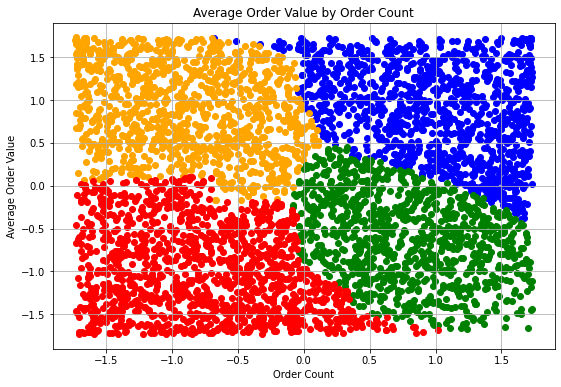

In [ ]:
# Visualize the clusters for average order value by order count
fig = plt.figure(figsize = (9,6))
plt.scatter(
    four_clusters.loc[four_clusters['Cluster'] == 0]['OrderCount'], 
    four_clusters.loc[four_clusters['Cluster'] == 0]['AvgOrderValue'],
    c='blue')

plt.scatter(
    four_clusters.loc[four_clusters['Cluster'] == 1]['OrderCount'], 
    four_clusters.loc[four_clusters['Cluster'] == 1]['AvgOrderValue'],
    c='orange')

plt.scatter(
    four_clusters.loc[four_clusters['Cluster'] == 2]['OrderCount'], 
    four_clusters.loc[four_clusters['Cluster'] == 2]['AvgOrderValue'],
    c='green')

plt.scatter(
    four_clusters.loc[four_clusters['Cluster'] == 3]['OrderCount'], 
    four_clusters.loc[four_clusters['Cluster'] == 3]['AvgOrderValue'],
    c='red')

plt.title('Average Order Value by Order Count')
plt.xlabel('Order Count')
plt.ylabel('Average Order Value')

plt.grid()
plt.show()

The customers in red have low average order value and low order count, meaning they are low-value customers. The customers in blue have high average order value and high order counts, indicating they are the highest value customers. The customers in orange have high average order value but lower order count, meaning they place fewer orders for higher priced products. 

Visualize the clusters for average order value by total sales.  

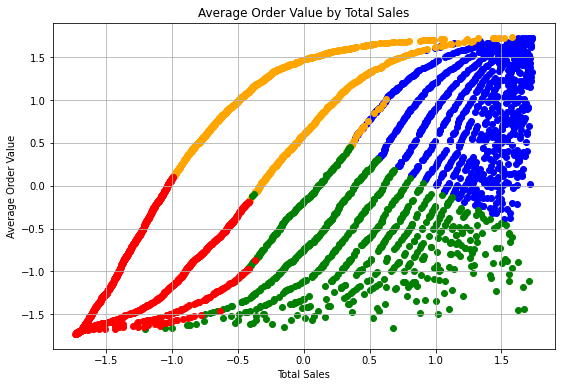

In [ ]:
# Visualize the clusters for average order value by total sales.  
fig = plt.figure(figsize = (9,6))
plt.scatter(
    four_clusters.loc[four_clusters['Cluster'] == 0]['TotalSales'], 
    four_clusters.loc[four_clusters['Cluster'] == 0]['AvgOrderValue'],
    c='blue')

plt.scatter(
    four_clusters.loc[four_clusters['Cluster'] == 1]['TotalSales'], 
    four_clusters.loc[four_clusters['Cluster'] == 1]['AvgOrderValue'],
    c='orange')

plt.scatter(
    four_clusters.loc[four_clusters['Cluster'] == 2]['TotalSales'], 
    four_clusters.loc[four_clusters['Cluster'] == 2]['AvgOrderValue'],
    c='green')

plt.scatter(
    four_clusters.loc[four_clusters['Cluster'] == 3]['TotalSales'], 
    four_clusters.loc[four_clusters['Cluster'] == 3]['AvgOrderValue'],
    c='red')

plt.title('Average Order Value by Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Average Order Value')

plt.grid()
plt.show()

The customers in blue have high total sales and high average order value, meaning they are the highest value customers. The customers in orange have high average order value but lower total sales, meaning they place fewer orders for higher priced products. The customers in red and green are high opportunity customers.

Let's identify the customers who are in the highest value cluster. The same code can be used for the other clusters by changing the cluster number and data frame name. 

In [ ]:
# Identify the customers in the high value cluster. 
high_value_cluster = four_clusters.loc[four_clusters['Cluster'] == 0]
high_value_cluster

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12347.0,1.479522,1.026356,1.431195,0
12348.0,0.956639,0.344231,1.149155,0
12356.0,1.271161,-0.043970,1.611035,0
12359.0,1.582514,0.871076,1.641140,0
12360.0,1.239471,-0.043177,1.596775,0
...,...,...,...,...
18259.0,1.154701,0.339478,1.563500,0
18260.0,1.217288,1.242640,0.599335,0
18263.0,0.619934,0.642116,0.446431,0


Let's identify the best selling items within all the clusters.

In [ ]:
pd.DataFrame(retail.groupby('Description').count()['StockCode'].sort_values(ascending=False).head())

,StockCode
Description,
WHITE HANGING HEART T-LIGHT HOLDER,2070
REGENCY CAKESTAND 3 TIER,1905
JUMBO BAG RED RETROSPOT,1662
ASSORTED COLOUR BIRD ORNAMENT,1418
PARTY BUNTING,1416


Let's identify the best selling items within the highest value cluster. The same code can be used for the other clusters by changing the cluster number and data frame name.

In [ ]:
# Identify the best-selling items within the highest value cluster.
high_value_cluster = four_clusters.loc[four_clusters['Cluster'] == 0]

pd.DataFrame(retail.loc[retail['CustomerID'].isin(high_value_cluster.index)].groupby(
    'Description').count()['StockCode'].sort_values(ascending=False).head())

,StockCode
Description,
REGENCY CAKESTAND 3 TIER,1199
JUMBO BAG RED RETROSPOT,1151
WHITE HANGING HEART T-LIGHT HOLDER,1081
LUNCH BAG RED RETROSPOT,943
PARTY BUNTING,852
